<a href="https://colab.research.google.com/github/Abdelmenam-Tarek-Abdelmenam/Face-mask_detection/blob/main/mask_detection_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packeges

In [1]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

%matplotlib inline  


# Initial variable



In [2]:
dirveLinkBase = r"drive/MyDrive/"
colabLinkBase = dirveLinkBase + "Colab Notebooks/";
faceDetector = cv.CascadeClassifier(colabLinkBase + "haarcascade_frontalface_default.xml") # read haar file
maskModel = load_model(colabLinkBase + "mask_detector.model") # read te model

# Helper functions

In [3]:
def showImg(img):
  plt.imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))
  plt.axis('off')
  plt.show()

# detection function

In [4]:
def preparePredictions(frame ):
  facesPred = faceDetector.detectMultiScale(frame,1.3,5)
  faces = []
  locs = []
  preds = []
  
  for (startX,startY,widht,hieght) in facesPred :
    # determine face place
    endX = startX + widht 
    endY = startY + hieght

    # deal with ROI of face 
    face = frame[startY:endY, startX:endX] 
    face = cv.cvtColor(face, cv.COLOR_BGR2RGB)
    face = cv.resize(face, (224, 224))
    face = img_to_array(face)
    face = preprocess_input(face)

    faces.append(face)
    locs.append((startX, startY, endX, endY))

  if len(faces) > 0: # make sure i have faces
      faces = np.array(faces, dtype="float32")
      # detect with my pretrained model
      preds = maskModel.predict(faces, batch_size=32)

  return (locs, preds)

# process image function

In [6]:
def processPhoto(img):
  # detect faces
  (locs, preds) = preparePredictions(frame) # detect mask and faces

  for (box, pred) in zip(locs, preds):
      (startX, startY, endX, endY) = box # face ROI

      # know image label
      (mask, withoutMask) = pred
      label = "Mask" if mask > withoutMask else "No Mask"
      color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
      label = "{} {:.2f}%".format(label, max(mask, withoutMask) * 100)

      # deow in image 
      cv.putText(frame, label, (startX, startY - 10),
      cv.FONT_HERSHEY_SIMPLEX,.7, color, 4)
      cv.rectangle(frame, (startX, startY), (endX, endY), color, 5)
  return frame

# Detect from photo

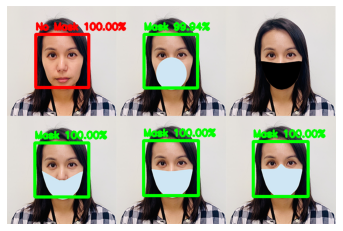

In [7]:
# read the imag
frame = cv.imread(colabLinkBase + "DoubleRow.png")
frame = processPhoto(frame)
showImg(frame)

#Detect from real time video

In [9]:
# display webcam 
vid = cv.VideoCapture(0)

# display the video
while True:
    state,frame = vid.read()
    frame =  processPhoto(frame)
    cv.imshow("video" , frame)
    if (cv.waitKey(33) & 0xff == ord("q")) : 
        vid.release()
        break # q in keyboard to leave

# Close any opened windows
cv.destroyAllWindows